<h1>Содержание<span class="tocSkip"></span></h1>
<br>
<div class="toc">
    <ul class="toc-item">
        <li>
            <span>
                <a href="#1-Подготовка-окружения">
                    <span class="toc-item-num">1&nbsp;&nbsp;</span>
                    Подготовка окружения
                </a>
            </span>
        </li>
        <li>
            <span>
                <a href="#2-Подготовка-данных">
                    <span class="toc-item-num">2&nbsp;&nbsp;</span>
                    Подготовка данных
                </a>
            </span>
            <ul class="toc-item">
                <li>
                    <span>
                        <a href="#2.1-Загрузка-данных">
                            <span class="toc-item-num">2.1&nbsp;&nbsp;</span>
                            Загрузка данных
                        </a>
                    </span>
                </li>
                <li>
                    <span>
                        <a href="#2.2-Преобразование-в-датасет">
                            <span class="toc-item-num">2.2&nbsp;&nbsp;</span>
                            Преобразование в датасет
                        </a>
                    </span>
                </li>
            </ul>
        </li>
        <li>
            <span>
                <a href="#3-Построение-модели">
                    <span class="toc-item-num">3.&nbsp;&nbsp;</span>
                    Построение модели
                </a>
            </span>
            <ul class="toc-item">
                <li>
                    <span>
                        <a href="#3.1-Базовая-модель">
                            <span class="toc-item-num">3.1&nbsp;&nbsp;</span>
                            Базовая модель
                        </a>
                    </span>
                    <ul class="toc-item">
                        <li>
                            <span>
                                <a href="#3.1.1-Тестирование-модели-на-одном-изображении">
                                    <span class="toc-item-num">3.1.1&nbsp;&nbsp;</span>
                                    Тестирование модели на одном изображении
                                </a>
                            </span>
                        </li>
                        <li>
                            <span>
                                <a href="#3.1.2-Обучение-модели">
                                    <span class="toc-item-num">3.1.2&nbsp;&nbsp;</span>
                                    Обчение модели
                                </a>
                            </span>
                        </li>
                    </ul>
                </li>
                <li>
                    <span>
                        <a href="#3.2-Модель-с-аугментацией-данных">
                            <span class="toc-item-num">3.2&nbsp;&nbsp;</span>
                            Модель с аугментацией данных
                        </a>
                    </span>
                    <ul class="toc-item">
                        <li>
                            <span>
                                <a href="#3.2.1-RandomHorizontalFlip">
                                    <span class="toc-item-num">3.2.1&nbsp;&nbsp;</span>
                                    RandomHorizontalFlip
                                </a>
                            </span>
                        </li>
                        <li>
                            <span>
                                <a href="#3.2.2-TrivialAugmentWide">
                                    <span class="toc-item-num">3.2.2&nbsp;&nbsp;</span>
                                    TrivialAugmentWide
                                </a>
                            </span>
                        </li>
                    </ul>
                </li>
                <li>
                    <span>
                        <a href="#3.3-Сравнение-моделей">
                            <span class="toc-item-num">3.3&nbsp;&nbsp;</span>
                            Сравнение моделей
                        </a>
                    </span>
                </li>
                <li>
                    <span>
                        <a href="#3.4-Тестирование-модели">
                            <span class="toc-item-num">3.4&nbsp;&nbsp;</span>
                            Тестирование модели
                        </a>
                    </span>
                </li>
            </ul>
        </li>
        <li>
            <span>
                <a href="#4-Общий-вывод">
                    <span class="toc-item-num">4&nbsp;&nbsp;</span>
                    Общий вывод
                </a>
            </span>
        </li>
    </ul>
</div>

# Генеративно-состязательная сеть

**Постановка задачи:** натренировать генеративную модель - автоэнкодер или генеративно-состязательную сеть для генерации изображений животных.

**Источник данных:** датасет [petfaces.tar.gz](http://www.soshnikov.com/permanent/data/petfaces.tar.gz) или [Oxford-IIIT](https://www.robots.ox.ac.uk/~vgg/data/pets/).

**Характер данных:** 

* *petfaces:* 35 пород домашних животных (12 пород кошек и 23 породы собак), по 200 изображений на каждый класс (изображение центрированы и уменьшены до небольшого размера) 
* *Oxford-IIIT:* 37 категорий животных по 200 изображений на каждый класс

**Основные этапы:** 

1. Начать экспериментировать с изображениями небольшого размера - 64x64 пикселя.
2. Затем посмотреть, получится ли увеличить размер до 128x128 или 256x256.

<div style="background-color: blue; height: 2px; margin: 10px 0;"></div>

## 1 Подготовка окружения

Установка необходимых библиотек:

In [1]:
%%capture --no-display
import torch
if '1.13' not in torch.__version__:
    !pip install torch==1.13.1+cu117 torchvision==0.14.1+cu117 torchaudio==0.13.1 --extra-index-url https://download.pytorch.org/whl/cu117

In [2]:
%%capture --no-display
!pip install wget

Импорт библиотек:

In [3]:
import numpy as np

import matplotlib.pyplot as plt
from PIL import Image
import contextlib

from tqdm.notebook import tqdm
from functools import reduce

import glob
import time
import os
import kaggle
import zipfile as zf

import torch
import torch.nn as nn
import torch.optim as optim

from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset

import cv2
import torchvision

from torchvision import datasets, transforms
from torchvision.utils import make_grid

from utils.plot_charts import *
from utils.useful_funcs import *

Задание случайных величин:

In [4]:
SEED = 42

np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

Получение текущего устройства:

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Текущее устройство:', device)

Текущее устройство: cuda


<div style="background-color: blue; height: 2px; margin: 10px 0;"></div>

## 2 Подготовка данных

### 2.1 Загрузка данных

Добавление папки `data`:

In [6]:
if os.path.isdir('data/') == False:
    os.mkdir('data/')

Задание пути до папки с набором данных:

In [7]:
path_data = 'data/oxford_pets'

Скачивание набора данных:

In [8]:
if os.path.isdir(path_data) == False:
    os.chdir('data/')
    
    !kaggle datasets download -d tanlikesmath/the-oxfordiiit-pet-dataset
    
    with zf.ZipFile('data/the-oxfordiiit-pet-dataset.zip', 'r') as file:
        file.extractall('data/')
    
    os.remove('the-oxfordiiit-pet-dataset.zip')
    os.rename('data/images', path_data)
    
    os.chdir('..')

Выведение на экран изображения и его параметров:

Путь к изображению: data\oxford_pets\images\shiba_inu_15.jpg
Класс изображения: images
Высота: 333 | Ширина: 500
Размерность изображения (333, 500, 3) -> [height, width, color_channels]


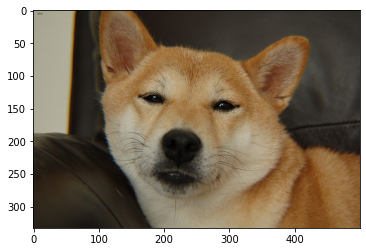

In [9]:
plot_random_image(path_data, depth='*/*')

---

### 2.2 Преобразование в датасет

Задание констант:

In [10]:
SIZE = 64

Задание трансформатора изображений:

In [11]:
data_transforms = transforms.Compose([
    transforms.Resize((SIZE, SIZE)), 
    transforms.ToTensor(),
])

Выведение на экран исходного и трансформированного изображений:

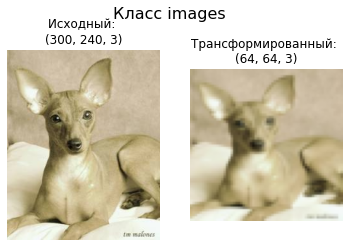

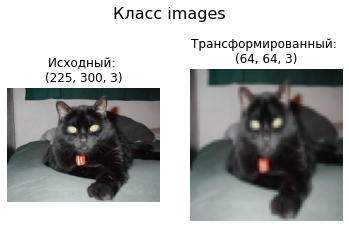

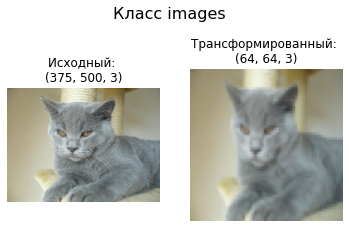

In [12]:
plot_transformed_images(data_transforms, 3, path_data, depth='*/*')

Формирование тренировочного датасета:

In [13]:
train_data = datasets.ImageFolder(
    root=path_data, 
    transform=data_transforms
)

Выведение на экран описания тренировочного датасета:

In [14]:
train_data

Dataset ImageFolder
    Number of datapoints: 7389
    Root location: data/oxford_pets
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
           )

Задание констант:

In [15]:
BATCH_SIZE = SIZE
N_WORKERS = os.cpu_count()

Преобразование датасета в загрузчик данных:

In [16]:
train_dataloader = DataLoader(
    dataset=train_data, 
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    num_workers=N_WORKERS,
    drop_last=True
)

<div style="background-color: blue; height: 2px; margin: 10px 0;"></div>

## 3 Построение модели

Задание функции сохранения итерации обработки изображения:

In [17]:
def save_image(epoch: int, 
               title: str,
               images: torch.Tensor, 
               n_col: int,
               path: str = 'visualization/') -> None:
    
    font_s = 12
    
    image_grid = make_grid(images, n_col)
    
    # PyTorch default shape is [C, H, W] but Matplotlib is [H, W, C]
    image_grid = image_grid.permute(1, 2, 0)
    
    image_grid = image_grid.cpu().numpy()

    plt.figure(figsize=(8,8), facecolor='white')
    plt.imshow(image_grid)
    plt.title(f'Epoch {epoch}', fontsize=font_s+4)
    
    plt.xticks([])
    plt.yticks([])
    
    plt.savefig(f'{path}images/{title}_{epoch:05d}.jpg')
    plt.close()

Задание функции создания GIF-изображения:

In [18]:
def create_gif(title: str, path: str = 'visualization/') -> None:
    
    images_path = f'{path}images/{title}_*.jpg'
    gif_path = f'{path}gifs/{title}.gif'

    with contextlib.ExitStack() as stack:
        images_stack = (stack.enter_context(Image.open(image))
                        for image in sorted(glob.glob(images_path)))

        image = next(images_stack)

        image.save(fp=gif_path, 
                   format='GIF', 
                   append_images=images_stack,
                   save_all=True, 
                   duration=150, 
                   disposal=2,
                   loop=0)

Задание констант:

In [19]:
TRAIN_SHAPE = train_data[0][0].shape
IMG_DIM = reduce(lambda x, y: x*y, TRAIN_SHAPE)

---

### 3.1 Генератор

Задание класса генератора:

In [20]:
class Generator(nn.Sequential):
    def __init__(self, sample_size: int, img_size: int) -> None:
        super().__init__(
            nn.Linear(sample_size, img_size * 2),
            nn.LeakyReLU(0.01),
            nn.Linear(img_size * 2, IMG_DIM),
            nn.Sigmoid())

        self.sample_size = sample_size

    def forward(self, batch_size: int) -> np.ndarray:
        z = torch.randn(batch_size, self.sample_size)
        output = super().forward(z)
        generated_images = output.reshape(batch_size, *TRAIN_SHAPE)
        
        return generated_images

Объявление класса генератора:

In [21]:
generator = Generator(100, SIZE)

---

### 3.2 Дискриминатор

Задание класса дискриминатора:

In [22]:
class Discriminator(nn.Sequential):
    def __init__(self, img_size: int, img_dim: int) -> None:
        super().__init__(
            nn.Linear(IMG_DIM, img_size * 2),
            nn.LeakyReLU(0.01),
            nn.Linear(img_size * 2, 1))
        
        self.img_dim = img_dim

    def forward(self, images: torch.Tensor, targets: torch.Tensor) -> np.ndarray:
        prediction = super().forward(images.reshape(-1, self.img_dim))
        loss = F.binary_cross_entropy_with_logits(prediction, targets)
        return loss

Объявление класса дискриминатора:

In [23]:
discriminator = Discriminator(SIZE, IMG_DIM)

---

### 3.3 Обучение модели

Задание класса обучения:

In [24]:
class GAN:
    
    def __init__(self, generator, discriminator) -> None:
        self.generator = generator
        self.discriminator = discriminator
        
        self.real_targets = torch.ones(BATCH_SIZE, 1)
        self.fake_targets = torch.zeros(BATCH_SIZE, 1)
        
        
    def train(self, 
              n_epochs: int, 
              dataloader: torch.utils.data.dataloader.DataLoader,
              optim_dis: torch.optim,
              optim_gen: torch.optim,
              img_title: str,
              n_col: int = 8,
              n_epochs_check: int = 10) -> None:
        
        for epoch in tqdm(range(n_epochs), 'Training process'):

            losses_dis, losses_gen = [], []

            for images, labels in dataloader:
                # discriminator
                # image inputs + real targets
                self.discriminator.train()
                loss_dis = self.discriminator(images, self.real_targets)
                
                generator.eval()
                with torch.no_grad():
                    generated_images = self.generator(BATCH_SIZE)

                # generated image inputs + fake targets
                loss_dis += discriminator(generated_images, self.fake_targets)

                # backward
                optim_dis.zero_grad()
                loss_dis.backward()
                optim_dis.step()
                
                
                # generator
                generator.train()
                generated_images = generator(BATCH_SIZE)

                # generated image inputs + real targets
                self.discriminator.eval()
                loss_gen = self.discriminator(generated_images, self.real_targets)
                
                # backward
                optim_gen.zero_grad()
                loss_gen.backward()
                optim_gen.step()
                
                
                losses_dis.append(loss_dis.item())
                losses_gen.append(loss_gen.item())

            if epoch == n_epochs_check or epoch == n_epochs - 1:
                print(f'Epoch {epoch+1} | ',
                      f'Loss Discriminator: {np.mean(losses_dis)} |',
                      f'Loss Generator: {np.mean(losses_gen)}')

            # save images
            save_image(epoch+1, img_title, generator(BATCH_SIZE), n_col=n_col)
            
        self.img_title = img_title
        create_gif(img_title)
       
    
    def print_generation_gif(self, path: str = 'visualization/') -> None:
        from IPython.display import Image

        with open(f'{path}gifs/{self.img_title}.gif', 'rb') as file:
            display(Image(file.read()))

---

Задание констант:

In [25]:
N_EPOCHS = 500
LEARN_R = 1e-4

Объявление экземпляра класса:

In [26]:
gan_64 = GAN(generator, discriminator)

Обучение модели:

In [ ]:
gan_64.train(
    n_epochs=N_EPOCHS,
    dataloader=train_dataloader,
    optim_dis=torch.optim.Adam(discriminator.parameters(), lr=LEARN_R),
    optim_gen=torch.optim.Adam(generator.parameters(), lr=LEARN_R),
    img_title='gan_64'
)

Training process:   0%|          | 0/500 [00:00<?, ?it/s]

Выведение на экран результата обучения:

In [ ]:
gan_64.print_generation_gif()

<div style="background-color: blue; height: 2px; margin: 10px 0;"></div>

## 4 Увеличение размера изображения

### 4.1 Размер 128x128

Задание констант:

In [ ]:
SIZE = 128

Задание трансформатора изображений:

In [ ]:
data_transforms = transforms.Compose([
    transforms.Resize((SIZE, SIZE)), 
    transforms.ToTensor(),
])

Выведение на экран исходного и трансформированного изображений:

In [ ]:
plot_transformed_images(data_transforms, 3, path_data, depth='*/*')

Формирование тренировочного датасета:

In [ ]:
train_data = datasets.ImageFolder(
    root=path_data, 
    transform=data_transforms
)

Выведение на экран описания тренировочного датасета:

In [ ]:
train_data

Задание констант:

In [ ]:
BATCH_SIZE = SIZE
N_WORKERS = os.cpu_count()

Преобразование датасета в загрузчик данных:

In [ ]:
train_dataloader = DataLoader(
    dataset=train_data, 
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    num_workers=N_WORKERS,
    drop_last=True
)

Задание констант:

In [ ]:
TRAIN_SHAPE = train_data[0][0].shape
IMG_DIM = reduce(lambda x, y: x*y, TRAIN_SHAPE)

Объявление классов генератора и дискриминатора:

In [ ]:
generator = Generator(100, SIZE)
discriminator = Discriminator(SIZE, IMG_DIM)

Объявление экземпляра класса:

In [ ]:
gan_128 = GAN(generator, discriminator)

Обучение модели:

In [ ]:
gan_128.train(
    n_epochs=N_EPOCHS,
    dataloader=train_dataloader,
    optim_dis=torch.optim.Adam(discriminator.parameters(), lr=LEARN_R),
    optim_gen=torch.optim.Adam(generator.parameters(), lr=LEARN_R),
    img_title='gan_128',
    n_col=int(SIZE/8)
)

Выведение на экран результата обучения:

In [ ]:
gan_128.print_generation_gif()

---

### 4.2 Размер 256x256

Задание констант:

In [ ]:
SIZE = 256

Задание трансформатора изображений:

In [ ]:
data_transforms = transforms.Compose([
    transforms.Resize((SIZE, SIZE)), 
    transforms.ToTensor(),
])

Выведение на экран исходного и трансформированного изображений:

In [ ]:
plot_transformed_images(data_transforms, 3, path_data, depth='*/*')

Формирование тренировочного датасета:

In [ ]:
train_data = datasets.ImageFolder(
    root=path_data, 
    transform=data_transforms
)

Выведение на экран описания тренировочного датасета:

In [ ]:
train_data

Задание констант:

In [ ]:
BATCH_SIZE = SIZE
N_WORKERS = os.cpu_count()

Преобразование датасета в загрузчик данных:

In [ ]:
train_dataloader = DataLoader(
    dataset=train_data, 
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    num_workers=N_WORKERS,
    drop_last=True
)

Задание констант:

In [ ]:
TRAIN_SHAPE = train_data[0][0].shape
IMG_DIM = reduce(lambda x, y: x*y, TRAIN_SHAPE)

Объявление классов генератора и дискриминатора:

In [ ]:
generator = Generator(100, SIZE)
discriminator = Discriminator(SIZE, IMG_DIM)

Объявление экземпляра класса:

In [ ]:
gan_256 = GAN(generator, discriminator)

Обучение модели:

In [ ]:
gan_256.train(
    n_epochs=N_EPOCHS,
    dataloader=train_dataloader,
    optim_dis=torch.optim.Adam(discriminator.parameters(), lr=LEARN_R),
    optim_gen=torch.optim.Adam(generator.parameters(), lr=LEARN_R),
    img_title='gan_256',
    n_col=int(SIZE/8)
)

Выведение на экран результата обучения:

In [ ]:
gan_256.print_generation_gif()

<div style="background-color: blue; height: 2px; margin: 10px 0;"></div>

## 5 Общий вывод

<div style="text-align: center; font-size: 20px; padding: 15px 0;">
    <a href="#Содержание" data-toc-modified-id="Содержание" style="text-decoration: none; color: #296eaa; border: 2px dashed #296eaa; opacity: 0.8; border-radius: 3px; padding: 10px 80px;">
        В начало файла ↑
    </a>
</div>